In [1]:
import pandas as pd
import time
import os
import pickle

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint

import numpy as np
import shap
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

# enable memory growth
physical_devices = tf.config.list_physical_devices('GPU')

for d in physical_devices:
    tf.config.experimental.set_memory_growth(d, True)

import xgboost
import shap

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [2]:
gamble_dataset = pd.read_csv("./dataset/raw_gamble.csv")
gamble_dataset = pd.DataFrame(gamble_dataset.drop('Unnamed: 0', axis=1))

ad_dataset = pd.read_csv("./dataset/raw_gambleList.csv")
ad_dataset = pd.DataFrame(ad_dataset.drop('Unnamed: 0', axis=1))

white_dataset = pd.read_csv("./dataset/raw_white2.csv")
white_dataset = pd.DataFrame(white_dataset.drop('Unnamed: 0', axis=1))

In [3]:
size_gamble_dataset = len(gamble_dataset) # 0 0 4 18 0 30 8 0 0 22
size_ad_dataset = len(ad_dataset)
size_white_dataset = len(white_dataset)

print(size_gamble_dataset)
print(size_ad_dataset)
print(size_white_dataset)

1233
632
485


In [4]:
total_dataset = pd.concat([gamble_dataset, ad_dataset, white_dataset])
total_dataset = total_dataset.fillna(0)

In [5]:
columns_total_data = total_dataset.columns

In [6]:
progress_total_dataset = np.where(total_dataset>0, 1, 0)

In [7]:
pre_total_dataset = pd.DataFrame(progress_total_dataset, columns=columns_total_data)

pre_gamble_dataset = pd.DataFrame(pre_total_dataset.iloc[:1233], columns=columns_total_data)
pre_ad_dataset = pd.DataFrame(pre_total_dataset.iloc[1233: 1865], columns=columns_total_data)
pre_white_dataset = pd.DataFrame(pre_total_dataset.iloc[1865:], columns=columns_total_data)

pre_gamble_dataset['correct_label'] = 0
pre_ad_dataset['correct_label'] = 1
pre_white_dataset['correct_label'] = 2

## 데이터셋 train, validation, test 분할

In [8]:
# Shuffle
gamble = pre_gamble_dataset.sample(frac=1)
ad = pre_ad_dataset.sample(frac=1)
white = pre_white_dataset.sample(frac=1)

# 데이터셋 나누기 학습용 90% 테스트용 10%
gamble_train = gamble.sample(frac=0.8)
gamble_test = gamble.drop(gamble_train.index)

ad_train = ad.sample(frac=0.8)
ad_test = ad.drop(ad_train.index)

white_train = white.sample(frac=0.8)
white_test = white.drop(white_train.index)

In [9]:
gamble_validation = gamble_test.sample(frac=0.5)
gamble_test = gamble_test.drop(gamble_validation.index)

ad_validation = ad_test.sample(frac=0.5)
ad_test = ad_test.drop(ad_validation.index)

white_validation = white_test.sample(frac=0.5)
white_test = white_test.drop(white_validation.index)

## gamble vs ad

In [10]:
train = pd.concat([gamble_train, ad_train], axis=0)
validation = pd.concat([gamble_validation, ad_validation], axis=0)
test = pd.concat([gamble_test, ad_test], axis=0)

train = train.sample(frac=1)
validation = validation.sample(frac=1)
test = test.sample(frac=1)

In [11]:
y_train = train['correct_label'].to_numpy()
x_train = pd.DataFrame(train.drop(['correct_label'], axis=1))
x_train = np.array(x_train)

y_validation = validation['correct_label'].to_numpy()
x_validation = pd.DataFrame(validation.drop(['correct_label'], axis=1))
x_validation = np.array(x_validation)

y_test = test['correct_label'].to_numpy()
x_test = pd.DataFrame((test.drop(['correct_label'], axis=1)))
x_test = np.array(x_test)

In [12]:
# train an XGBoost model
gam_ad_model = xgboost.XGBRFClassifier().fit(X=x_train, y=y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:38:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [13]:
y_pred = gam_ad_model.predict(x_validation)
accuracy = accuracy_score(y_pred, y_validation)
print('accuracy :', accuracy)

accuracy : 0.9572192513368984


In [14]:
y_pred = gam_ad_model.predict(x_test)
accuracy = accuracy_score(y_pred, y_test)
print('accuracy :', accuracy)

accuracy : 0.978494623655914


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


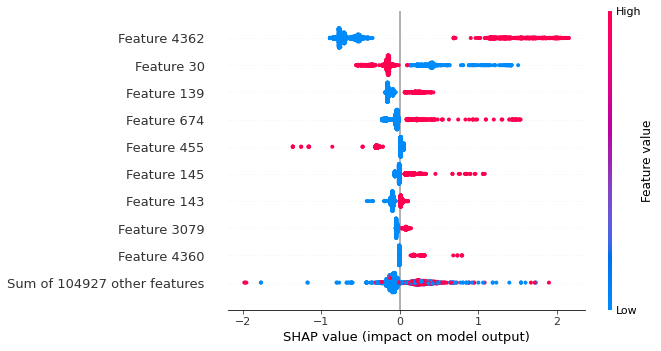

In [15]:
explainer = shap.Explainer(gam_ad_model)
shap_values = explainer(x_train)

# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

In [57]:
shap_values.values[:,3].min()

-0.056210894

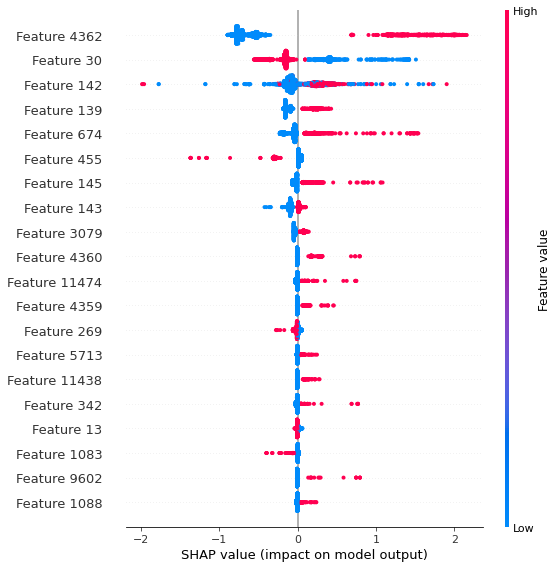

In [109]:
shap.summary_plot(shap_values, x_train, plot_type='dot')

In [213]:
shap_values.values

array([[-0.00093735,  0.00049023, -0.00090768, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00222769,  0.00358566,  0.01615054, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00263505,  0.00016473, -0.00170398, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.00021282,  0.00182748,  0.00175335, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00022309,  0.00037771, -0.00141921, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00022309,  0.0004024 ,  0.00347267, ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

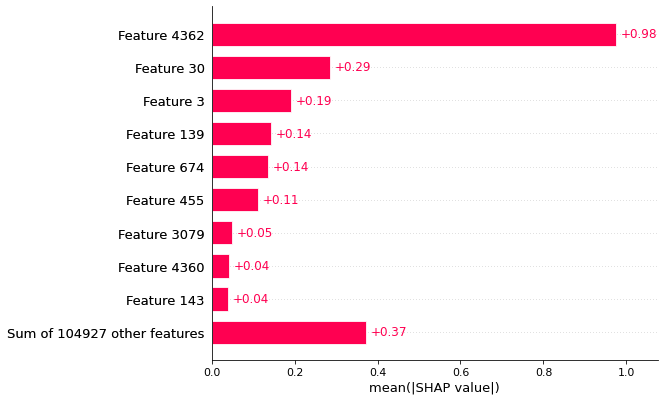

In [16]:
shap.plots.bar(shap_values)

In [36]:
print(columns_total_data[4362], columns_total_data[30], columns_total_data[3], columns_total_data[139], columns_total_data[674], columns_total_data[455], columns_total_data[3079], columns_total_data[4360], columns_total_data[143])

검증 아이디 가입 먹튀 주소 씨티 업체 스포츠토토 사이트


## gamble vs normal

In [18]:
train = pd.concat([gamble_train, white_train], axis=0)
validation = pd.concat([gamble_validation, white_validation], axis=0)
test = pd.concat([gamble_test, white_test], axis=0)

train = train.sample(frac=1)
validation = validation.sample(frac=1)
test = test.sample(frac=1)

In [19]:
y_train = train['correct_label'].to_numpy()
x_train = pd.DataFrame(train.drop(['correct_label'], axis=1))
x_train = np.array(x_train)

y_validation = validation['correct_label'].to_numpy()
x_validation = pd.DataFrame(validation.drop(['correct_label'], axis=1))
x_validation = np.array(x_validation)

y_test = test['correct_label'].to_numpy()
x_test = pd.DataFrame((test.drop(['correct_label'], axis=1)))
x_test = np.array(x_test)

In [20]:
# train an XGBoost model
gam_white_model = xgboost.XGBRFClassifier().fit(X=x_train, y=y_train)

[01:01:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [21]:
y_pred = gam_white_model.predict(x_validation)
accuracy = accuracy_score(y_pred, y_validation)
print('accuracy :', accuracy)

accuracy : 0.9651162790697675


In [22]:
y_pred = gam_white_model.predict(x_test)
accuracy = accuracy_score(y_pred, y_test)
print('accuracy :', accuracy)

accuracy : 0.9941860465116279


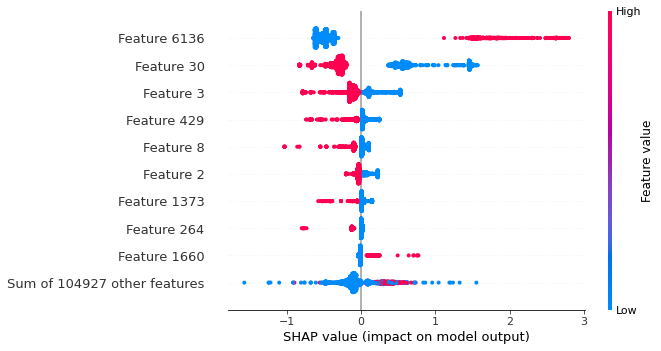

In [23]:
explainer = shap.Explainer(gam_white_model)
shap_values = explainer(x_train)

# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

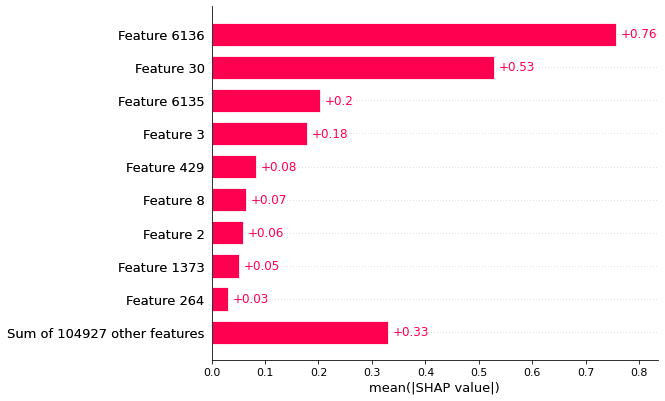

In [24]:
shap.plots.bar(shap_values)

In [35]:
print(columns_total_data[6136], columns_total_data[30], columns_total_data[6135], columns_total_data[3], columns_total_data[429], columns_total_data[8], columns_total_data[2], columns_total_data[1373], columns_total_data[264])

방침 아이디 정보처리 가입 ID 카지노 회원 LOGIN 닉네임


## ad vs normal

In [26]:
train = pd.concat([ad_train, white_train], axis=0)
validation = pd.concat([ad_validation, white_validation], axis=0)
test = pd.concat([ad_test, white_test], axis=0)

train = train.sample(frac=1)
validation = validation.sample(frac=1)
test = test.sample(frac=1)

In [27]:
y_train = train['correct_label'].to_numpy()
x_train = pd.DataFrame(train.drop(['correct_label'], axis=1))
x_train = np.array(x_train)

y_validation = validation['correct_label'].to_numpy()
x_validation = pd.DataFrame(validation.drop(['correct_label'], axis=1))
x_validation = np.array(x_validation)

y_test = test['correct_label'].to_numpy()
x_test = pd.DataFrame((test.drop(['correct_label'], axis=1)))
x_test = np.array(x_test)

In [28]:
# train an XGBoost model
ad_white_model = xgboost.XGBRFClassifier().fit(X=x_train, y=y_train)

[01:02:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [29]:
y_pred = gam_white_model.predict(x_validation)
accuracy = accuracy_score(y_pred, y_validation)
print('accuracy :', accuracy)

accuracy : 0.42342342342342343


In [30]:
y_pred = gam_white_model.predict(x_test)
accuracy = accuracy_score(y_pred, y_test)
print('accuracy :', accuracy)

accuracy : 0.42857142857142855


In [31]:
explainer = shap.Explainer(ad_white_model)
shap_values = explainer(x_train)

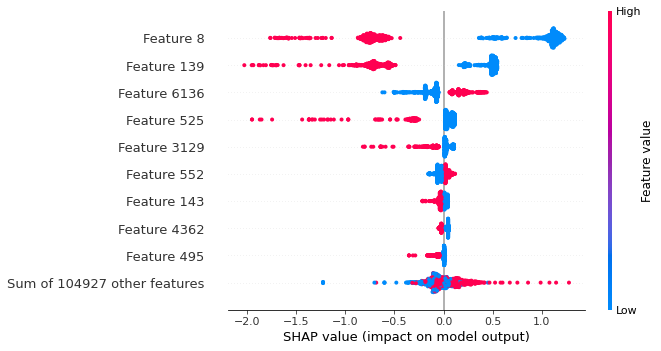

In [32]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

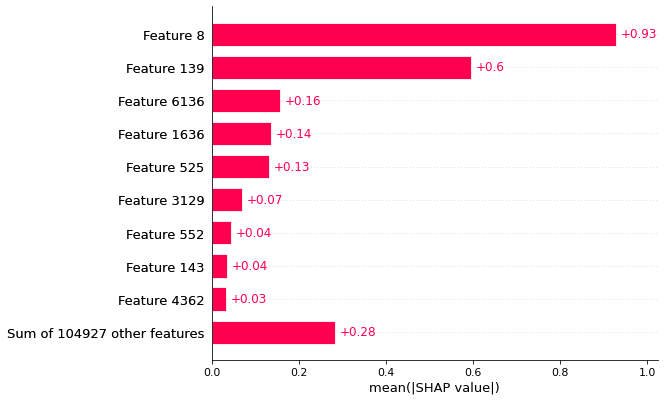

In [33]:
shap.plots.bar(shap_values)

In [34]:
print(columns_total_data[8], columns_total_data[139], columns_total_data[142], columns_total_data[6136], columns_total_data[525], columns_total_data[3129], columns_total_data[552], columns_total_data[1636], columns_total_data[495])

카지노 먹튀 토토 방침 도메인 접속 보기 소개 텔레
